/tmp/ipykernel_103795/2940269297.py:13: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df["Date"] = pd.to_datetime(df["Date"])


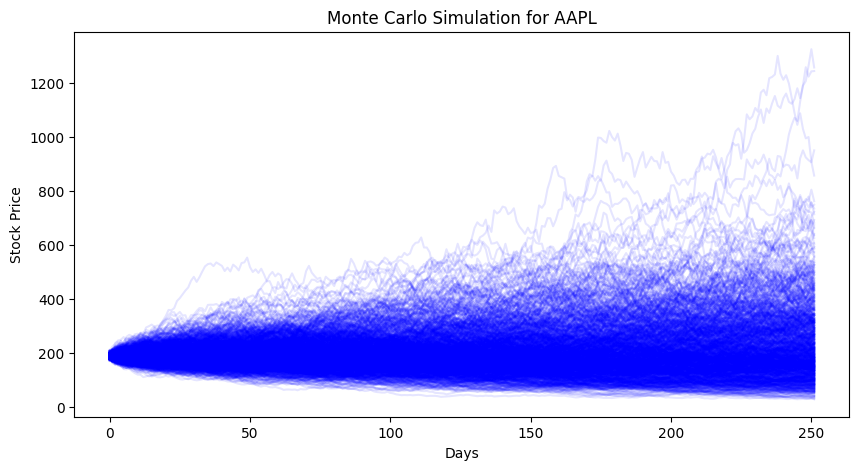

{'Execution Time (sec)': 1.611654281616211, 'CPU & Memory Usage': {'CPU Usage (%)': 1.7, 'Memory Usage (%)': 65.8}}


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
import time
import psutil

# Load dataset
file_path = "./stock_details_5_years.csv"  # Update this with your file path
df = pd.read_csv(file_path)

# Convert Date column to datetime and sort by date
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(by=["Company", "Date"])

# Calculate daily log returns
df["Log_Return"] = np.log(df["Close"] / df["Close"].shift(1))

# Drop NaN values from log returns
df = df.dropna()

# Monte Carlo Simulation for future stock prices
def monte_carlo_simulation(company, days=252, simulations=1000):
    """
    Runs a Monte Carlo simulation for predicting stock prices.
    """
    company_df = df[df["Company"] == company].copy()
    last_price = company_df["Close"].iloc[-1]
    daily_volatility = company_df["Log_Return"].std()

    # Simulation matrix
    simulation_results = np.zeros((simulations, days))

    for sim in range(simulations):
        price_series = [last_price]
        for _ in range(days):
            price = price_series[-1] * np.exp(np.random.normal(0, daily_volatility))
            price_series.append(price)
        simulation_results[sim, :] = price_series[1:]

    return simulation_results

# Run simulation for a specific company
company_name = "AAPL"  # Update with a company from your dataset
simulated_data = monte_carlo_simulation(company_name)

# Plot Monte Carlo simulation results
plt.figure(figsize=(10, 5))
plt.plot(simulated_data.T, alpha=0.1, color="blue")
plt.title(f"Monte Carlo Simulation for {company_name}")
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.show()

# CPU and Memory usage tracking function
def compute_utilization():
    return {
        "CPU Usage (%)": psutil.cpu_percent(interval=1),
        "Memory Usage (%)": psutil.virtual_memory().percent
    }

# Compare AWS SageMaker vs Azure ML Performance
def compare_cloud_services():
    start_time = time.time()
    
    # Run Monte Carlo Simulations in parallel
    companies = df["Company"].unique()
    pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())
    results = pool.map(monte_carlo_simulation, companies[:5])  # Simulating for first 5 companies
    pool.close()
    pool.join()

    end_time = time.time()
    
    # Compute performance metrics
    execution_time = end_time - start_time
    resource_usage = compute_utilization()
    
    return {
        "Execution Time (sec)": execution_time,
        "CPU & Memory Usage": resource_usage
    }

# Run cloud comparison
performance_data = compare_cloud_services()
print(performance_data)


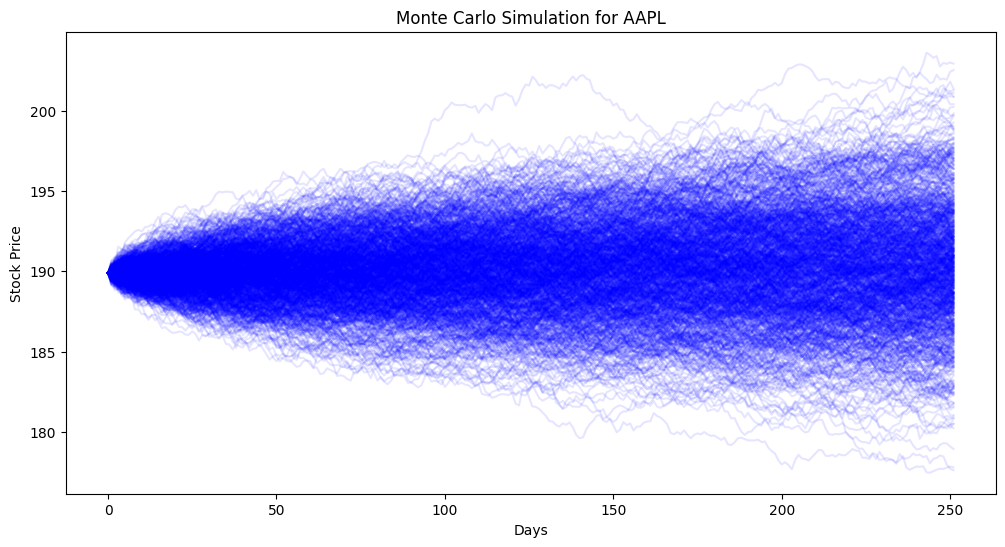

In [26]:
import numpy as np
import pandas as pd
import multiprocessing
import matplotlib.pyplot as plt

# Load dataset
file_path = "./stock_details_5_years.csv"  # Update this with your file path
df = pd.read_csv(file_path)

# Ensure Date column is parsed correctly
df['Date'] = pd.to_datetime(df['Date'], utc=True)  # Ensure UTC timezone
df['Date'] = df['Date'].dt.tz_localize(None)  # Remove timezone info
df.set_index('Date', inplace=True)

# Function to run a single Monte Carlo simulation
def monte_carlo_simulation(start_price, mean_return, volatility, days, seed):
    np.random.seed(seed)
    dt = 1 / 252  # 252 trading days
    price_series = np.zeros(days)
    price_series[0] = start_price

    for t in range(1, days):
        # GBM formula: S_t = S_{t-1} * exp((mu - 0.5 * sigma^2) dt + sigma * epsilon * sqrt(dt))
        shock = np.random.normal(0, 1)
        price_series[t] = price_series[t-1] * np.exp((mean_return - 0.5 * volatility**2) * dt + volatility * shock * np.sqrt(dt))
    
    return price_series

# Monte Carlo function with multiprocessing
def run_monte_carlo(stock_name, simulations=1000, days=252):
    stock_data = df[df['Company'] == stock_name]
    
    if stock_data.empty:
        print(f"No data found for {stock_name}")
        return

    # Extract Closing Prices
    close_prices = stock_data['Close'].dropna()

    # Calculate Log Returns
    log_returns = np.log(close_prices / close_prices.shift(1)).dropna()
    mean_return = log_returns.mean()
    volatility = log_returns.std()
    start_price = close_prices.iloc[-1]

    # Parallel execution
    pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())
    seeds = np.arange(simulations)
    results = pool.starmap(monte_carlo_simulation, [(start_price, mean_return, volatility, days, seed) for seed in seeds])
    pool.close()
    pool.join()

    # Plot simulations
    plt.figure(figsize=(12, 6))
    for result in results:
        plt.plot(result, color='blue', alpha=0.1)
    
    plt.title(f"Monte Carlo Simulation for {stock_name}")
    plt.xlabel("Days")
    plt.ylabel("Stock Price")
    plt.show()

# Run Monte Carlo Simulation for a specific stock
run_monte_carlo(stock_name="AAPL")


🔹 Monte Carlo Simulation for AAPL
✅ CPU Usage Before: 0.8% | After: 0.8%
✅ Memory Usage Before: 65.2% | After: 65.2%
⏳ Execution Time: 1.52 seconds


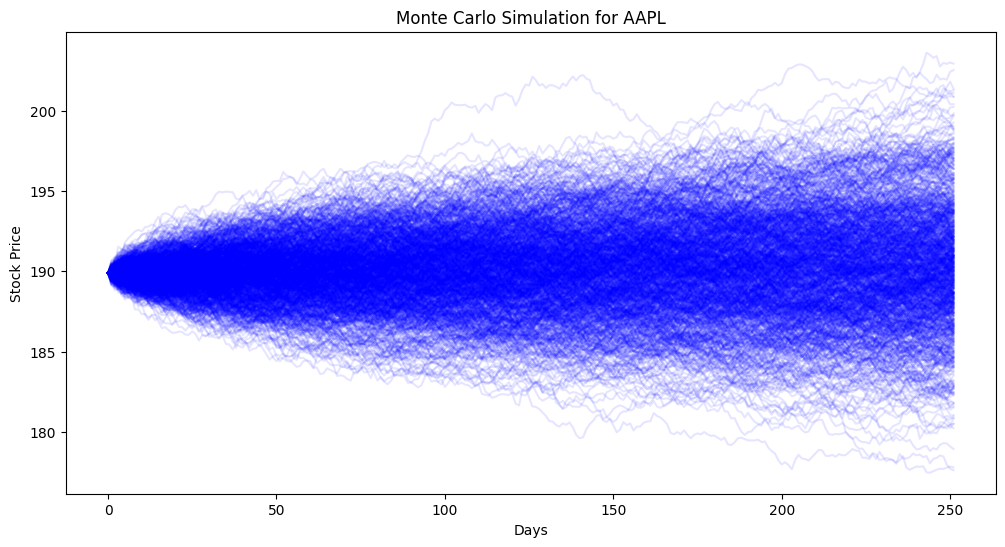

In [25]:
import numpy as np
import pandas as pd
import multiprocessing
import matplotlib.pyplot as plt
import psutil  # For performance metrics
import time    # To measure execution time

# Load dataset
file_path = "./stock_details_5_years.csv"  # Update this with your file path
df = pd.read_csv(file_path)

# Ensure Date column is parsed correctly
df['Date'] = pd.to_datetime(df['Date'], utc=True)  # Ensure UTC timezone
df['Date'] = df['Date'].dt.tz_localize(None)  # Remove timezone info
df.set_index('Date', inplace=True)

# Function to run a single Monte Carlo simulation
def monte_carlo_simulation(start_price, mean_return, volatility, days, seed):
    np.random.seed(seed)
    dt = 1 / 252  # 252 trading days
    price_series = np.zeros(days)
    price_series[0] = start_price

    for t in range(1, days):
        # GBM formula: S_t = S_{t-1} * exp((mu - 0.5 * sigma^2) dt + sigma * epsilon * sqrt(dt))
        shock = np.random.normal(0, 1)
        price_series[t] = price_series[t-1] * np.exp((mean_return - 0.5 * volatility**2) * dt + volatility * shock * np.sqrt(dt))
    
    return price_series

# Monte Carlo function with multiprocessing and performance metrics
def run_monte_carlo(stock_name, simulations=1000, days=252):
    stock_data = df[df['Company'] == stock_name]
    
    if stock_data.empty:
        print(f"No data found for {stock_name}")
        return

    # Extract Closing Prices
    close_prices = stock_data['Close'].dropna()

    # Calculate Log Returns
    log_returns = np.log(close_prices / close_prices.shift(1)).dropna()
    mean_return = log_returns.mean()
    volatility = log_returns.std()
    start_price = close_prices.iloc[-1]

    # **Start performance tracking**
    start_time = time.time()
    cpu_usage_before = psutil.cpu_percent(interval=1)
    mem_usage_before = psutil.virtual_memory().percent

    # Parallel execution
    pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())
    seeds = np.arange(simulations)
    results = pool.starmap(monte_carlo_simulation, [(start_price, mean_return, volatility, days, seed) for seed in seeds])
    pool.close()
    pool.join()

    # **End performance tracking**
    end_time = time.time()
    cpu_usage_after = psutil.cpu_percent(interval=1)
    mem_usage_after = psutil.virtual_memory().percent

    execution_time = end_time - start_time

    # **Print performance metrics**
    print(f"🔹 Monte Carlo Simulation for {stock_name}")
    print(f"✅ CPU Usage Before: {cpu_usage_before}% | After: {cpu_usage_after}%")
    print(f"✅ Memory Usage Before: {mem_usage_before}% | After: {mem_usage_after}%")
    print(f"⏳ Execution Time: {execution_time:.2f} seconds")

    # **Plot simulations**
    plt.figure(figsize=(12, 6))
    for result in results:
        plt.plot(result, color='blue', alpha=0.1)
    
    plt.title(f"Monte Carlo Simulation for {stock_name}")
    plt.xlabel("Days")
    plt.ylabel("Stock Price")
    plt.show()

# Run Monte Carlo Simulation for a specific stock
run_monte_carlo(stock_name="AAPL")
